In [2]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import anndata as ad
import episcanpy.api as epi #only worked with pip install from git
from scipy.io import mmread
from scipy.sparse import csr_matrix

sc.settings.verbosity = 3
#sc.logging.print_versions() #throws an error

In [3]:
SCRNA_DIR = '../data/ma-2020/rna/'
SCATAC_DIR = '../data/ma-2020/atac/'
META_PATH = '../data/ma-2020/celltype.txt'

# Annotation

In [9]:
anno = pd.read_csv(META_PATH, sep='\t')

In [10]:
anno

,atac.bc,rna.bc,celltype
0,R1.01.R2.01.R3.06.P1.07,R1.01.R2.01.R3.06.P1.55,Dermal Fibrobalst
1,R1.01.R2.03.R3.68.P1.07,R1.01.R2.03.R3.68.P1.55,Dermal Fibrobalst
2,R1.01.R2.05.R3.15.P1.05,R1.01.R2.05.R3.15.P1.53,Dermal Fibrobalst
3,R1.01.R2.05.R3.40.P1.07,R1.01.R2.05.R3.40.P1.55,Dermal Fibrobalst
4,R1.01.R2.05.R3.49.P1.07,R1.01.R2.05.R3.49.P1.55,Dermal Fibrobalst
...,...,...,...
34769,R1.92.R2.79.R3.05.P1.08,R1.92.R2.79.R3.05.P1.56,Melanocyte
34770,R1.93.R2.20.R3.18.P1.05,R1.93.R2.20.R3.18.P1.53,Melanocyte
34771,R1.93.R2.80.R3.62.P1.07,R1.93.R2.80.R3.62.P1.55,Melanocyte
34772,R1.93.R2.91.R3.82.P1.08,R1.93.R2.91.R3.82.P1.56,Melanocyte


In [11]:
anno_atac = anno.set_index('atac.bc')
anno_rna = anno.set_index('rna.bc')

# RNAseq

In [6]:
scrna = sc.read(SCRNA_DIR + 'GSM4156608_skin.late.anagen.rna.counts.txt', cache = True)

Only considering the two last: ['.counts', '.txt'].
Only considering the two last: ['.counts', '.txt'].
... reading from cache file cache/..-data-ma-2020-rna-GSM4156608_skin.late.anagen.rna.counts.h5ad


In [7]:
scrna = ad.AnnData(scrna.X.T, obs=pd.DataFrame(index=scrna.var_names), var=pd.DataFrame(index=scrna.obs_names))

In [8]:
scrna.var_names_make_unique()

In [9]:
sc.pp.filter_cells(scrna, min_genes=1)
sc.pp.filter_genes(scrna, min_cells=1)

In [10]:
scrna.raw = scrna

## Quality Control

normalizing counts per cell
    finished (0:00:20)


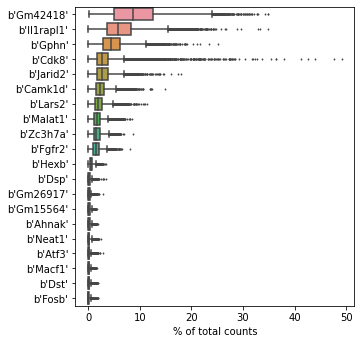

In [11]:
sc.pl.highest_expr_genes(scrna, n_top=20)

In [12]:
# no MT genes
sc.pp.calculate_qc_metrics(scrna, percent_top=None, inplace=True)
scrna

AnnData object with n_obs × n_vars = 42948 × 23296
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

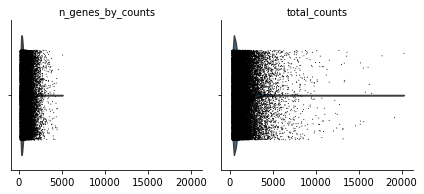

In [13]:
sc.pl.violin(scrna, ['n_genes_by_counts', 'total_counts'], jitter=0.3, multi_panel=True)

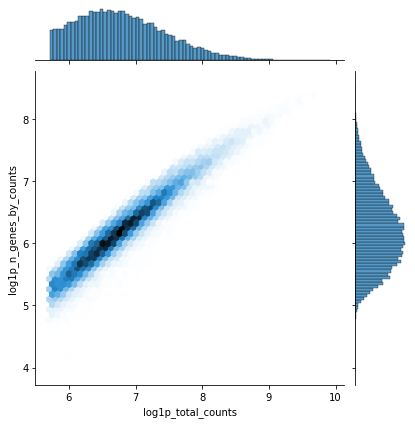

In [14]:
sns.jointplot("log1p_total_counts", "log1p_n_genes_by_counts", data=scrna.obs, kind='hex')

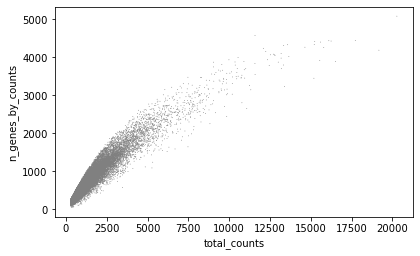

In [15]:
sc.pl.scatter(scrna, x='total_counts', y='n_genes_by_counts')

In [16]:
sc.pp.filter_cells(scrna, min_genes=100)
sc.pp.filter_genes(scrna, min_cells=3)
scrna = scrna[scrna.obs.n_genes_by_counts < 2500, :]
scrna

filtered out 16 cells that have less than 100 genes expressed


filtered out 1964 genes that are detected in less than 3 cells


View of AnnData object with n_obs × n_vars = 42618 × 21332
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## Normalization

In [17]:
sc.pp.normalize_total(scrna, target_sum=1e4)
sc.pp.log1p(scrna)

normalizing counts per cell
    finished (0:00:15)


## Highly variable genes

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:39)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


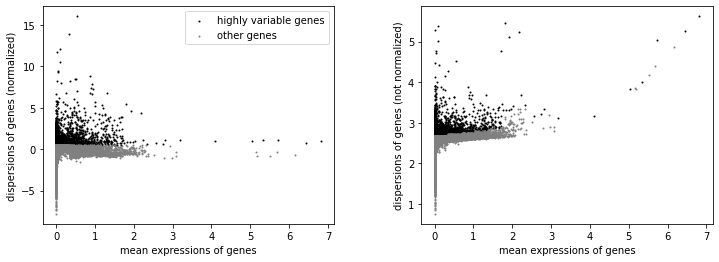

number of highly variable genes = 3999


In [18]:
sc.pp.highly_variable_genes(scrna, n_top_genes=4000)
sc.pl.highly_variable_genes(scrna)
print('number of highly variable genes =', scrna.var.highly_variable.sum())

In [19]:
scrna = scrna[:, scrna.var.highly_variable]
scrna

View of AnnData object with n_obs × n_vars = 42618 × 3999
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## Annotation

In [28]:
scrna.obs.index = scrna.obs.index.astype(str).str.replace(',', '.')

In [30]:
scrna.obs = scrna.obs.join(anno_rna.celltype, how='left', sort=False)

In [45]:
scrna = scrna[~(scrna.obs['celltype'] == 'nan')]

## Visualization

In [46]:
sc.tl.pca(scrna, random_state=0, svd_solver='arpack', n_comps=50)

computing PCA
    on highly variable genes


    with n_comps=50
    finished (0:00:52)


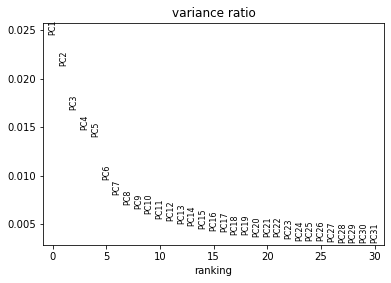

In [47]:
sc.pl.pca_variance_ratio(scrna)

In [49]:
sc.pp.neighbors(scrna, n_pcs=24)
sc.tl.umap(scrna)

computing neighbors
    using 'X_pca' with n_pcs = 24


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:39)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:31)


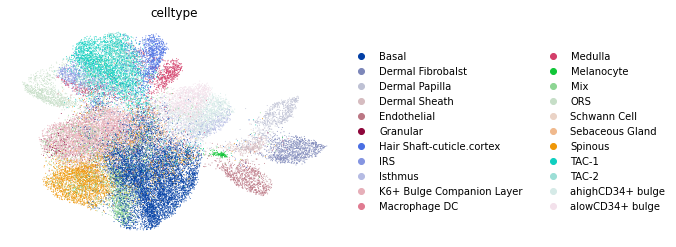

In [50]:
sc.pl.umap(scrna, color=['celltype'], frameon=False, ncols=1)

# ATACseq

In [6]:
mat = mmread(SCATAC_DIR +'GSM4156597_skin.late.anagen.counts.txt')

In [7]:
with open(SCATAC_DIR + 'GSM4156597_skin.late.anagen.barcodes.txt') as f:
    barcodes = f.readlines() 
    barcodes = [x[:-1] for x in barcodes]

In [8]:
with open(SCATAC_DIR + 'GSM4156597_skin.late.anagen.peaks.bed') as f:
    var_names = f.readlines()
    var_names = ["_".join(x[:-1].split('\t')) for x in var_names]

In [9]:
adata = ad.AnnData(mat.T, obs=pd.DataFrame(index=barcodes), var=pd.DataFrame(index=var_names))

In [10]:
adata.X = csr_matrix(adata.X)

## Binarization

In [11]:
epi.pp.binarize(adata)

In [12]:
print(np.max(adata.X))

1.0


## Quality Control

In [13]:
# remove any potential empty features or barcodes
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)

In [14]:
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]

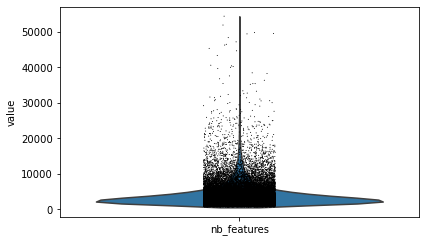

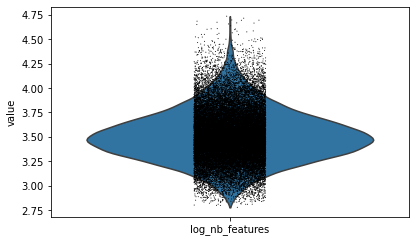

In [15]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

## Selecting variable peaks

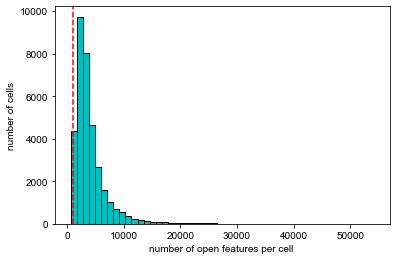

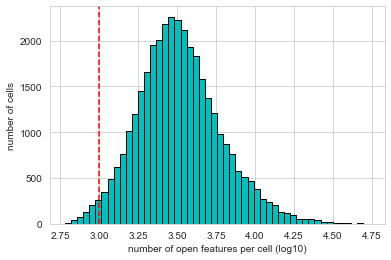

In [16]:
# plot cell coverage
epi.pp.coverage_cells(adata, binary=True, log=False, bins=50,
               threshold=1000)
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50,
               threshold=1000)

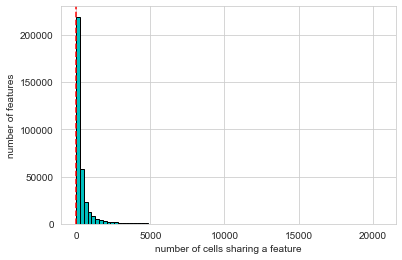

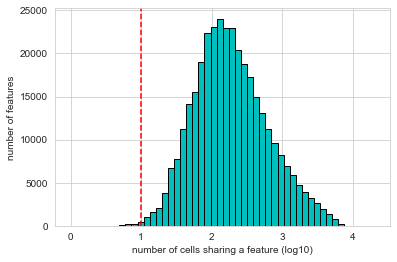

In [17]:
# minimum number of cells sharing a feature
min_cells = 10
epi.pp.coverage_features(adata, binary=True, log=False, 
                        threshold=min_cells)
epi.pp.coverage_features(adata, binary=True, log=True, 
                        threshold=min_cells)

In [18]:
min_features = 1000
epi.pp.filter_cells(adata, min_features=min_features)
adata

filtered out 608 cells that have less than 1000 genes expressed


AnnData object with n_obs × n_vars = 34166 × 344592
    obs: 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'

In [19]:
min_cells = 10
epi.pp.filter_features(adata, min_cells=min_cells)
adata

filtered out 660 genes that are detected in less than 10 cells


AnnData object with n_obs × n_vars = 34166 × 343932
    obs: 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'

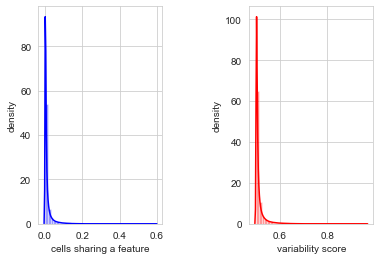

In [20]:
epi.pp.cal_var(adata)

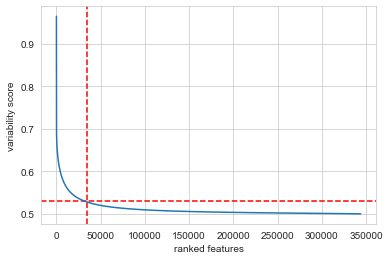

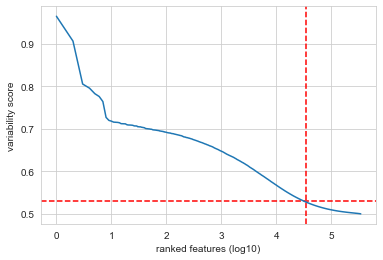

In [21]:
min_score_value = 0.53
nb_feature_selected = 35000
epi.pl.variability_features(adata, log=None, min_score=min_score_value, nb_features=nb_feature_selected)
epi.pl.variability_features(adata, log='log10', min_score=min_score_value, nb_features=nb_feature_selected)

In [22]:
adata.raw = adata

In [23]:
adata = epi.pp.select_var_feature(adata,
                                  nb_features=nb_feature_selected,
                                  show=False,
                                  copy=True)

## Quality Control after filtering

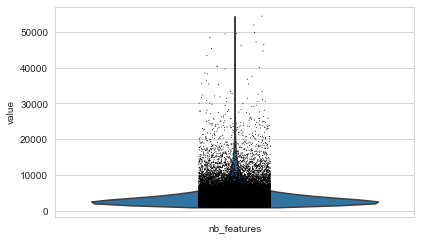

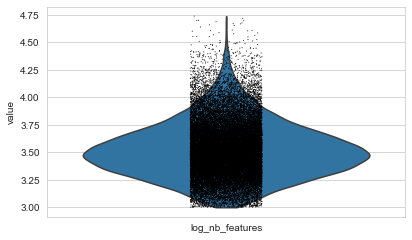

In [24]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

In [25]:
epi.pp.filter_cells(adata, max_features=40000)

Trying to set attribute `.obs` of view, copying.


In [28]:
adata

AnnData object with n_obs × n_vars = 34166 × 35027
    obs: 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

In [29]:
adata.write('ma-atac.h5ad')

## Annotation

In [13]:
adata.obs.index = adata.obs.index.astype(str)

In [19]:
adata.obs = adata.obs.join(anno_rna.celltype, how='left', sort=False)

In [20]:
adata = adata[~(adata.obs['celltype'] == 'nan')]

In [21]:
adata.write('ma-atac.h5ad')

Trying to set attribute `.obs` of view, copying.
... storing 'celltype' as categorical


## Visualization

In [4]:
adata = sc.read('ma-atac.h5ad')

In [22]:
sc.tl.pca(adata, random_state=0, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:07:20)


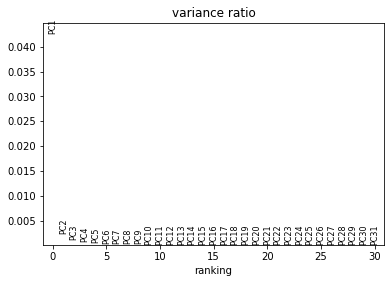

In [23]:
sc.pl.pca_variance_ratio(adata)

In [24]:
sc.pp.neighbors(adata, n_pcs=10)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 10


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:21)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:32)


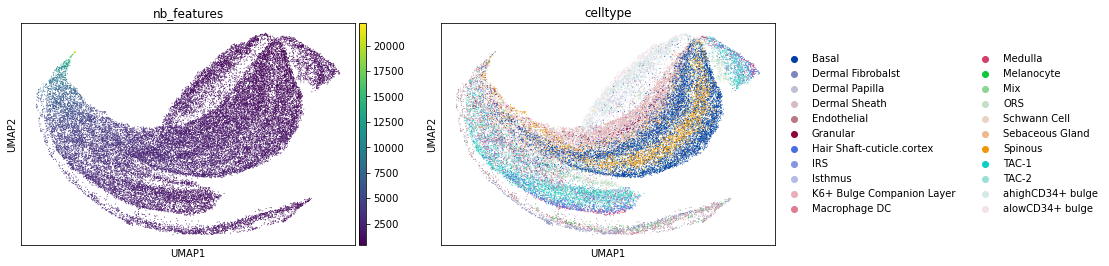

In [30]:
sc.pl.umap(adata, color=['nb_features', 'celltype'])

In [26]:
adata.write('ma-atac.h5ad')

# Save the results

In [43]:
scrna = sc.read('ma-rna.h5ad')

In [44]:
scrna.obs.index = scrna.obs.index.astype(str)

## Find common cells

In [45]:
com_index = set(scrna.obs.index) & set(adata.obs.index)
scrna = scrna[scrna.obs.index.isin(com_index)]
adata = adata[adata.obs.index.isin(com_index)]
print(scrna.shape, adata.shape)

(33893, 3999) (33893, 35027)


In [46]:
scrna.obs_names

Index(['R1.01.R2.01.R3.06.P1.55', 'R1.01.R2.01.R3.43.P1.56',
       'R1.01.R2.02.R3.21.P1.56', 'R1.01.R2.02.R3.38.P1.56',
       'R1.01.R2.02.R3.53.P1.54', 'R1.01.R2.03.R3.28.P1.53',
       'R1.01.R2.03.R3.61.P1.54', 'R1.01.R2.03.R3.68.P1.55',
       'R1.01.R2.03.R3.73.P1.56', 'R1.01.R2.03.R3.88.P1.53',
       ...
       'R1.96.R2.90.R3.70.P1.54', 'R1.96.R2.90.R3.72.P1.53',
       'R1.96.R2.91.R3.40.P1.54', 'R1.96.R2.91.R3.67.P1.54',
       'R1.96.R2.91.R3.88.P1.56', 'R1.96.R2.92.R3.27.P1.54',
       'R1.96.R2.92.R3.28.P1.56', 'R1.96.R2.92.R3.83.P1.54',
       'R1.96.R2.92.R3.85.P1.55', 'R1.96.R2.93.R3.20.P1.53'],
      dtype='object', length=33893)

In [68]:
# there was some problem saving this as h5ad because it was in byte format
scrna.uns['hvg']['flavor'] = 'seurat'

In [74]:
del scrna.uns

In [75]:
scrna

AnnData object with n_obs × n_vars = 33893 × 3999
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'celltype'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [76]:
scrna.write(SCRNA_DIR + 'expressions.h5ad')

In [42]:
adata.write(SCATAC_DIR  + 'peaks-binary.h5ad')